# Cross Validation with scikitlearn!

In [69]:
# imports
import torch
import torch.nn as nn
import numpy as np

from sklearn.model_selection import train_test_split

# importing iris dataset
import seaborn as sns
iris_dataset = sns.load_dataset('iris')

# direct access to torch.nn functions (without using classes)
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

---
## In this project:
#### The ratio of the data being split between training, testing, and dev sets will be parametrically explored.

### Transforming Data

In [70]:
# converting from pandas dataframe to pytorch tensor
torched_iris_dataset= torch.tensor(iris_dataset[iris_dataset.columns[0:4]].values).float() # only use first 4 columns, because last column is outcome variable or datatype.

# numeric transformation - transforming species name to a number (0-2)
iris_labels = torch.zeros(len(torched_iris_dataset), dtype=torch.long) # species 'setosa' will remain 0.
iris_labels[iris_dataset.species=='versicolor'] = 1
iris_labels[iris_dataset.species=='virginica'] = 2

## Using `train_test_split` to divide data into sets.
- Important note - Do NOT swap the order of columns / features when sampling data.
- The order of the rows should be randomized when sampling.

In [71]:
# Small example of how to use train_test_split

# fake dataset
fake_data = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
fake_labels = np.arange(10)>4
print(fake_data)
print(fake_labels)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
[False False False False False  True  True  True  True  True]


### Model Architecture (not the focus of this experiment)

In [72]:
def create_ANN_model():
    ANN_iris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3)
    )

    # Loss function
    loss_function = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(ANN_iris.parameters(), lr=0.01)

    return ANN_iris, loss_function, optimizer

## Training the Model
#### `test_train_split` will be used here to split the entire data set into the training set and the testing set.

In [73]:
def train_model(ratio_training_data, number_of_epochs, ANN_iris, loss_function, optimizer):
    
    # initialize losses
    losses_ary = torch.zeros(number_of_epochs)
    training_accuracy_ary = []
    testing_accuracy_ary = []

    # split data into training and testing sets
    training_data, testing_data, training_labels, testing_labels = train_test_split(torched_iris_dataset, iris_labels, train_size = ratio_training_data)

    # loop over epochs
    for epoch_IDX in range(number_of_epochs):

        # forward pass and calculate loss
        y_hat = ANN_iris(training_data)
        loss = loss_function(y_hat, training_labels)

        # backpropagation (learning)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate training accuracy
        training_accuracy_ary.append(100*torch.mean((torch.argmax(y_hat,axis=1) == training_labels).float()).item())

        # calculate testing accuracy
        predicted_testing_labels = torch.argmax(ANN_iris(testing_data),axis=1)
        testing_accuracy_ary.append(100*torch.mean((predicted_testing_labels == testing_labels).float()).item())

    return training_accuracy_ary, testing_accuracy_ary

### Quick Model Test
- Good to test that everything is working right and training as expected, especially before doing a larger parametric experiment.

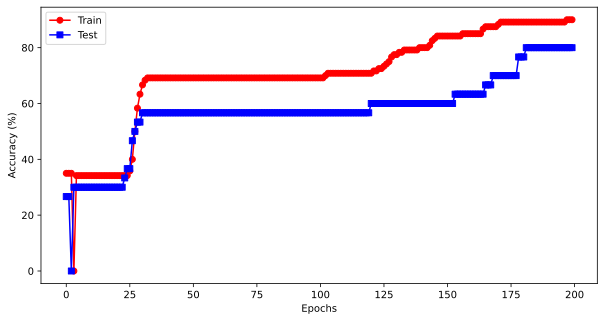

In [74]:
# create the model
iris_model, loss_func, opt = create_ANN_model()

# train the model
quick_training_accuracy, quick_testing_accuracy = train_model(0.8, 200, ANN_iris= iris_model, loss_function= loss_func, optimizer= opt)

# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(quick_training_accuracy,'ro-')
plt.plot(quick_testing_accuracy,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.show()

#### Interesting note: 
Overfitting can generally be estimated by examining the gap in performance between the training accuracy and the testing accuracy.
- Large gaps indicate that the model has a problem with too much (or not enough) overfitting.
- In most cases, training accuracy should be higher than testing accuracy.
<br><br>
---
---

# Parametric Experiment!
#### The ratio of *training to testing* will be parametrically varied to see how the model performs with the different dataset sizes.
- The training and testing accuracy will be recorded over several iterations.
- After the experiment is concluded, these accuracy will be compared.
- With this experiment, the process is subject to researcher overfitting. 
- In a more ideal situation, the dataset would be split into 3 groups. However, this dataset is just too small to do that.
    - Then the model could be iteratively trained and tuned with the training and devset, while the test set would be set aside and not used in the parametric part of this experiment.

In [75]:
# experiment parameters
training_set_sizes = np.linspace(0.2,0.95,10) # The percentage of training data will be varied from 20% to 95% with the number of points being 100.
epochs = 400

# initialize arrays to store accuracy results
all_training_accuracies = np.zeros((len(training_set_sizes), epochs))
all_testing_accuracies = np.zeros((len(training_set_sizes), epochs))

# loop over training set sizes
for i in range(len(training_set_sizes)):

    # create a fresh model
    ANN_iris, loss_function, optimizer = create_ANN_model()

    # train the model
    training_accuracy, testing_accuracy = train_model(training_set_sizes[i], epochs, ANN_iris, loss_function, optimizer)

    # store the results
    all_training_accuracies[i,:] = training_accuracy
    all_testing_accuracies[i,:] = testing_accuracy

### Graphing the Results

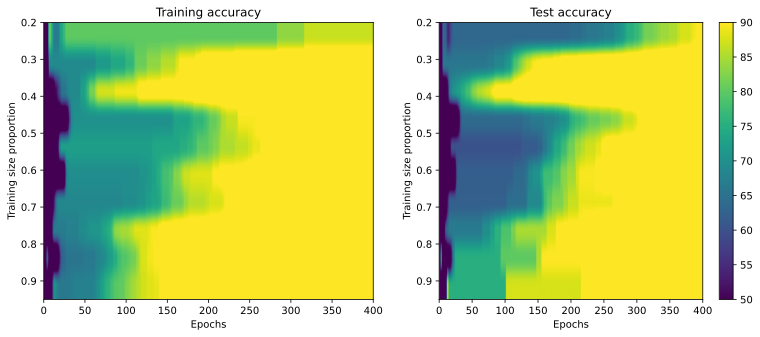

In [76]:
fig,ax = plt.subplots(1,2,figsize=(13,5))

ax[0].imshow(all_training_accuracies,aspect='auto',
             vmin=50,vmax=90, extent=[0,epochs,training_set_sizes[-1],training_set_sizes[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

p = ax[1].imshow(all_testing_accuracies,aspect='auto',
             vmin=50,vmax=90, extent=[0,epochs,training_set_sizes[-1],training_set_sizes[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')
fig.colorbar(p,ax=ax[1])

plt.show()

### Interpreting the Results.
- Generally this dataset is too small to try to find a relationship between accuracy and the sizes of the training and testing datasets.
- For the most part, the model has higher accuracy when the training set is in a larger proportion / ratio. 
    - This could be explored later with a larger dataset to see if it holds up.